In [1]:
import numpy as np
from environment import QuiverMutationEnvironment
from agent import Agent

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras.layers import Dense, Input

2024-10-01 02:05:09.676502: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 02:05:09.688873: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 02:05:09.692714: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-01 02:05:09.702867: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-01 02:05:10.445742: W tensorflow/compiler/tf2

In [2]:
quiver_adj = np.asarray([
    [0, 0, 1, 0, 0, 0],
    [1, 0, 0, 0, 1, 0],
    [0, 1, 0, 0, 0, 1],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 1, 0]
])

quiver_env = QuiverMutationEnvironment(quiver_adj)

In [3]:
# Initialize agent
model = tfk.Sequential([
    Input((quiver_env.random_state().shape[0],)),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(quiver_env.num_actions, activation='linear')
])

optim = tfk.optimizers.Adam(learning_rate = 1e-3)
model.compile(
    loss = tfk.losses.MeanSquaredError(),
    optimizer = optim,
    metrics = [tfk.metrics.MeanAbsoluteError()])

agent = Agent(model)

# Train the agent
agent.fit(quiver_env, num_epochs = 1000, verbosity = 1)

I0000 00:00:1727762711.880770   93145 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727762711.916315   93145 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727762711.916569   93145 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727762711.918154   93145 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

array([[6.30000000e+01, 9.94461765e-01],
       [6.40000000e+01, 9.67257599e-01],
       [6.50000000e+01, 8.77879605e-01],
       ...,
       [9.97000000e+02, 5.89619111e-03],
       [9.98000000e+02, 2.24193418e-03],
       [9.99000000e+02, 3.68512236e-04]])

In [4]:
graphs = [*map(lambda x: x.reshape(6,6), agent.walk(quiver_env.random_state(), quiver_env))]

In [5]:
def walk_agent(state, env, agent, max_steps = 32):
    path = [state]
    actions = []
    for _ in range(max_steps):
        action = agent.act(state)
        state, (_, done) = env.act(state, action)
        path.append(state)
        actions.append(action)
        if done:
            break
    return path, actions


In [6]:
np.asarray(walk_agent(quiver_env.random_state(), quiver_env, agent)[-1])+1

array([3, 6, 5, 4])

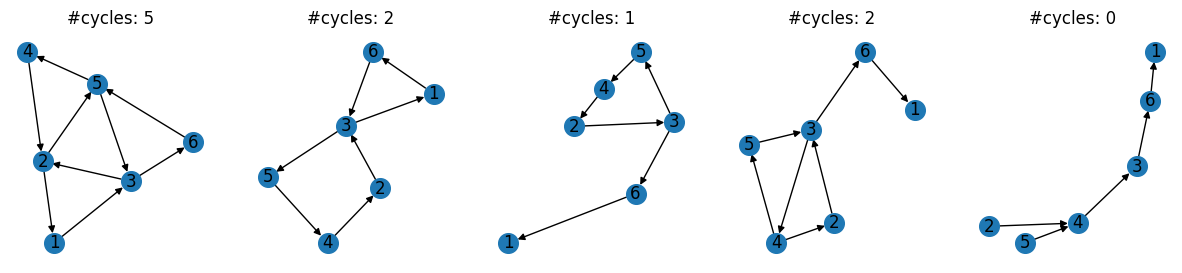

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,3))
for i, graph in enumerate(graphs):
    ax = fig.add_subplot(1, len(graphs), i+1)
    rows, cols = np.where(graph == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.DiGraph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size = 200,labels={i:i+1 for i in range(graph.shape[0])})
    ax.set_title(f"#cycles: {len([*nx.cycles.simple_cycles(gr)])}")

plt.savefig("RL_walk.png")